In [1]:
import numpy as np
import torch
import pandas as pd
import os

In [2]:
def set_seeds(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
set_seeds(42)

In [6]:
from castle.datasets import DAG, Topology, THPSimulation

dataset = 'You_Name_This_Run'
# Data Simulation for TTPM
true_causal_matrix = DAG.erdos_renyi(n_nodes=20, n_edges=40)
topology_matrix = np.array(Topology.erdos_renyi(n_nodes=40, n_edges=80))

simulator = THPSimulation(true_causal_matrix, topology_matrix, mu_range=(0.00003, 0.00005), alpha_range=(0.02, 0.03))
X = simulator.simulate(T=10000, max_hop=2)
sample_size = 200000
data = X.rename(columns={'event': 'alarm_id', 'timestamp': 'start_timestamp', 'node': 'device_id', 'duration': 'end_timestamp'})
data = data.iloc[:sample_size]
data['end_timestamp'] = data['end_timestamp'] + data['start_timestamp']

device_n = data['device_id'].nunique()
event_n = data['alarm_id'].nunique()

100%|██████████| 40/40 [00:00<00:00, 50.47it/s]


In [8]:
device_n, event_n

(40, 20)

In [9]:
from collections import deque

k_hop = 2

def find_k_hop_neighbors(adj_matr, k):
    """
    寻找每个节点的k跳邻居
    :param adj_matr: 对称的邻接矩阵
    :param k: 距离阈值
    :return: 包含每个节点的k跳邻居的字典
    """
    n = len(adj_matr)
    neighbors_dict = {i: [i] for i in range(n)}

    for node in range(n):
        visited = [False] * n
        visited[node] = True
        queue = deque([(node, 0)])
        while queue:
            curr_node, curr_dist = queue.popleft()
            if curr_dist > k:
                break
            for neighbor in range(n):
                if adj_matr[curr_node][neighbor] and not visited[neighbor]:
                    visited[neighbor] = True
                    neighbors_dict[node].append(neighbor)
                    queue.append((neighbor, curr_dist + 1))

    return neighbors_dict

nei_dict = find_k_hop_neighbors(topology_matrix, k_hop)

In [10]:
# normalization = data['start_timestamp'].max()/100
normalization = 1
seqs = []
nei_seqs = []
count_matr = np.zeros((device_n, event_n))
for device in range(device_n):
    filtered_data = data[data['device_id']==device]
    seq = torch.tensor(filtered_data[['alarm_id', 'start_timestamp', 'end_timestamp']].values, dtype=torch.float)
    alarm_counts = filtered_data['alarm_id'].value_counts()
    value_count = filtered_data['alarm_id'].value_counts().sort_index()
    count_matr[device, :] = value_count.reindex(np.arange(event_n), fill_value=0).values
    seqs.append(seq)

    nei_filtered_data = data[data['device_id'].isin(nei_dict[device])]
    nei_seqs.append(torch.tensor(nei_filtered_data[['alarm_id', 'start_timestamp', 'end_timestamp']].values, dtype=torch.float))

In [11]:
def count_bin(g):
    counts = torch.bincount(g)
    if counts.shape[0] < event_n:
        counts = torch.cat([counts, torch.zeros(event_n - counts.shape[0])])
    return counts

def cal_mask(seqs, nei_seqs):
    mask_len = 0
    Tc = 0
    for s in seqs:
        mask_len += s.shape[0]
        Tc += s[-1, 2]
    A_mask = torch.zeros((mask_len, event_n, event_n))
    mu_mask = torch.zeros((mask_len, event_n))
    mu_mask_2 = torch.ones(event_n) * Tc
    A_mask_2 = torch.zeros((event_n, event_n))
    count = 0
    for c in range(len(seqs)):
        seq = seqs[c]
        nei_seq = nei_seqs[c]
        #part1 loss
        for e in range(seq.shape[0]):
            time_e = seq[e, 1]
            g = nei_seq[(nei_seq[:, 1] < time_e) & (nei_seq[:, 2] > time_e), 0].to(torch.int64)
            A_mask[count, :, seq[e, 0].to(torch.int64)] = count_bin(g)
            mu_mask[count, seq[e, 0].to(torch.int64)] = 1
            # log(A * A_mask + mu * mu_mask)
            count += 1
        for nei_e in range(nei_seq.shape[0]):
            A_mask_2[nei_seq[nei_e, 0].to(torch.int64), :] += nei_seq[nei_e, 2] -nei_seq[nei_e, 1]
    return A_mask, mu_mask, A_mask_2, mu_mask_2


In [12]:
if os.path.exists('./Masks/{}_{}_masks.pth'.format(dataset, k_hop)):
    masks = torch.load('./Masks/{}_{}_masks.pth'.format(dataset, k_hop))
    A_mask, mu_mask, A_mask_2, mu_mask_2 = masks
else:
    A_mask, mu_mask, A_mask_2, mu_mask_2 = cal_mask(seqs, nei_seqs)
    torch.save([A_mask, mu_mask, A_mask_2, mu_mask_2], './Masks/{}_{}_masks.pth'.format(dataset, k_hop))

In [32]:
import torch
import torch.nn.functional as F
def loglikelihood(A, mu, A_mask, mu_mask, A_mask_2, mu_mask_2):
    A = F.softplus(A) * prior_mask
    mu = F.softplus(mu)
    LL = 0
    LL += torch.sum(torch.log(torch.sum(A.unsqueeze(0) * A_mask, dim=(1, 2)) + torch.sum(mu.unsqueeze(0) * mu_mask, dim=1)))
    LL -= torch.sum(mu * mu_mask_2)
    LL -= torch.sum(A * A_mask_2)
    return LL

def revsoftplus(A):
    return torch.log(torch.exp(A) - 1)

# 定义L1范数
def l1_norm(A):
    return torch.norm(F.softplus(A), p=1)


def acyc_norm(A):
    A = F.softplus(A) * prior_mask
    init_e = torch.eye(event_n).to(my_device)
    M = init_e + A * A / event_n
    E = torch.matrix_power(M, event_n - 1)
    h = (E.t() * M).sum() - event_n
    return h

def loss_fn(A, mu, A_mask, mu_mask, A_mask_2, mu_mask_2, lambda1 = 5e3, lambda2 = 5e3):
    L = loglikelihood(A, mu, A_mask, mu_mask, A_mask_2, mu_mask_2)
    l1 = lambda1 * l1_norm(A)
    l2 = lambda2 * acyc_norm(A)
    loss = -L + l1 +l2
    return loss


In [33]:
from tqdm import tqdm

my_device = 'cuda'

A = torch.ones((event_n, event_n), requires_grad=True, device=my_device) * 1e-7
prior_mask = torch.ones((event_n, event_n), device=my_device)
prior_mask.fill_diagonal_(0)
A = revsoftplus(A).detach().requires_grad_(True)

mu = torch.ones(event_n, requires_grad=True, device=my_device) * 1e-7
mu = mu.clone().detach().requires_grad_(True)

Loss = []
eps = [1000, 500]
A_li = [F.softplus(A).cpu().detach().numpy()]
for ep in eps:
    optimizer = torch.optim.Adam([A, mu], lr=0.05)
    for epoch in tqdm(range(ep)):
        optimizer.zero_grad()
        loss = loss_fn(A, mu, A_mask.to(my_device), mu_mask.to(my_device), A_mask_2.to(my_device), mu_mask_2.to(my_device))
        loss.backward()
        optimizer.step()
        Loss.append(loss.item())
        A_li.append(F.softplus(A).cpu().detach().numpy())

100%|██████████| 500/500 [00:08<00:00, 59.78it/s]


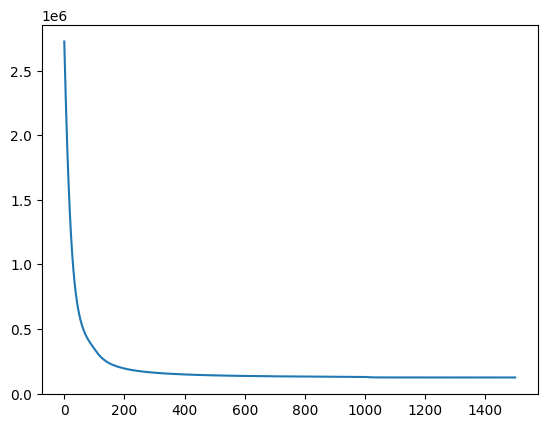

In [34]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(Loss)), Loss)

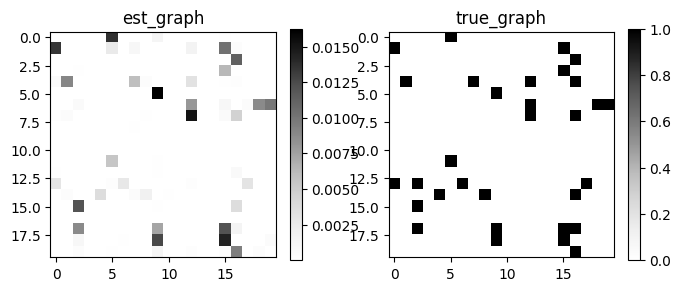

In [35]:
from castle.common import GraphDAG
wei_est_matr = F.softplus(A).cpu().detach().numpy()
GraphDAG(wei_est_matr, true_causal_matrix)